
## 1. 项目介绍
> 来自Kaggle的数据集包含了泰坦尼克号上 2224 名乘客和船员中 891 名的人口学数据和乘客基本信息。分析有哪些因素会让船上的人生还率更高？

> 1. 女性的生还率会比较高
2. 儿童的生还率会比较高
3. 乘员级别高的生还率会比较高

## 2. 数据清理

In [96]:
import pandas as pd
import numpy as np


# 读取csv文件
filename = "titanic_data.csv"
df = pd.read_csv(filename)

# 清理数据
def format_df(df):
    # 处理缺失的年龄值
    df["Age"] = df["Age"].fillna(0)
    # 转换年龄为浮点型
    df["Age"] = df["Age"].apply(float)
    return df


df = format_df(df)


def append_age_sex_column(c):
    if c["Age"] > 18:
        if c["Sex"] == "male":
            return "man"
        elif c["Sex"] == "female":
            return "woman"
        else:
            return np.NaN
    elif 0 < c["Age"] <= 18:
        return "child"
    else:
        return np.NaN


# 增加age_sex列（小于等于18岁的青少年为"Child"，大于18岁男子为"Man"，
# 大于18岁女子为"Woman")
df["Age_Sex"] = df.apply(append_age_sex_column, axis=1)

def calc_survival(df, key, *value):
    if key == "age":       
        series = df[(df.Age > value[0])
                   & (df.Age <= value[1])]["Survived"]
    elif key == "sex":
        series = df[df.Sex == value[0]]["Survived"]
    elif key == "level":
        series = df[df.Pclass == value[0]]["Survived"]
    elif key == "age_sex":
        series = df[df.Age_Sex == value[0]]["Survived"]
    elif key == "age_sex_level":
        series = df[(df.Age_Sex == value[0])
                    & (df.Pclass == value[1])]["Survived"]
    
    
    return series.sum(), series.shape[0], series.sum() / (series.shape[0] * 1.0)

df.info()
print type(df["Age"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Age_Sex        714 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
<class 'pandas.core.series.Series'>


In [ ]:
## 3. 分析数据
### 3.1. 按age组进行分析
#### 3.1.1. 分组方式
> 小于等于18岁的一组，大于18岁为一组

#### 3.1.2. 分析结果
> 从图中可以看出，儿童有139名，成人有575名，其中儿童的生还率>成人的生还率

Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11376f510>], dtype=object)

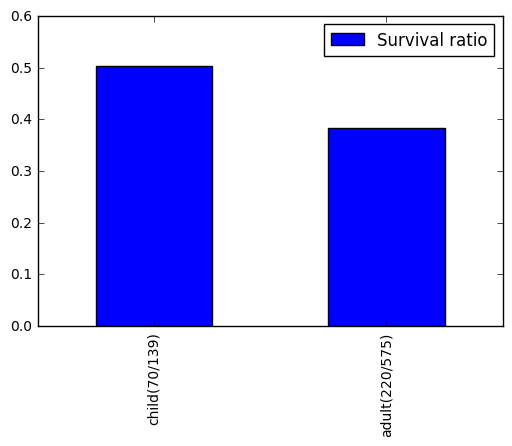

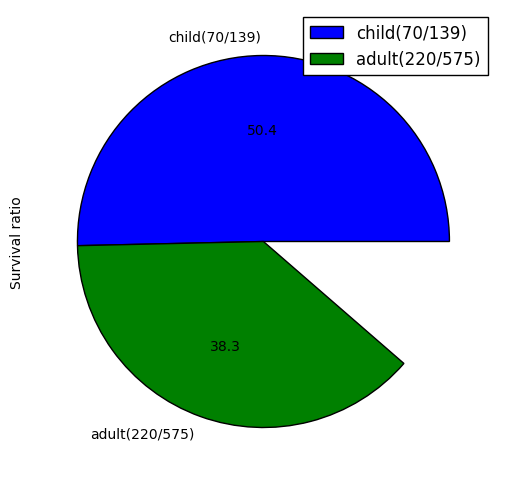

In [71]:
a1, a2, a3 = calc_survival(df, "age", 0, 18)
b1, b2, b3 = calc_survival(df, "age", 18, 100)
age_group_df = pd.DataFrame(
    data={"Survival ratio": [a3, b3]},
    index=["child", "adult"]
)


%pylab inline
import matplotlib.pyplot as plt

# 绘制直方图
age_group_df.index = [
    "child({0}/{1})".format(a1, a2), "adult({0}/{1})".format(b1, b2)
]
age_group_df.plot(kind="bar")

# 绘制饼图
age_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

### 3.2. 按sex组进行分析
#### 3.2.1. 分组方式
> 男性为一组，女性为一组

#### 3.2.2. 分析结果
> 从图中可以看出，男性有577名，女性有314名，其中女性的生还率远远>男性的生还率

Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x112baac10>], dtype=object)

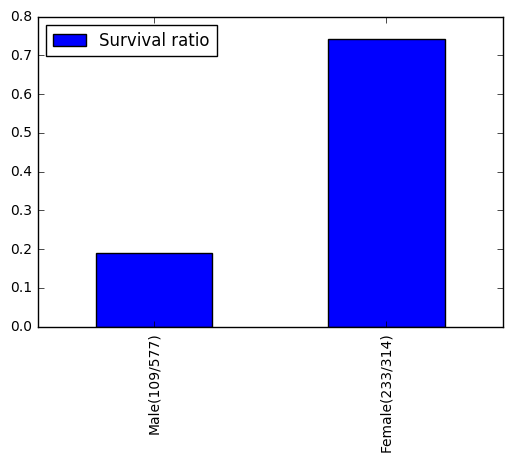

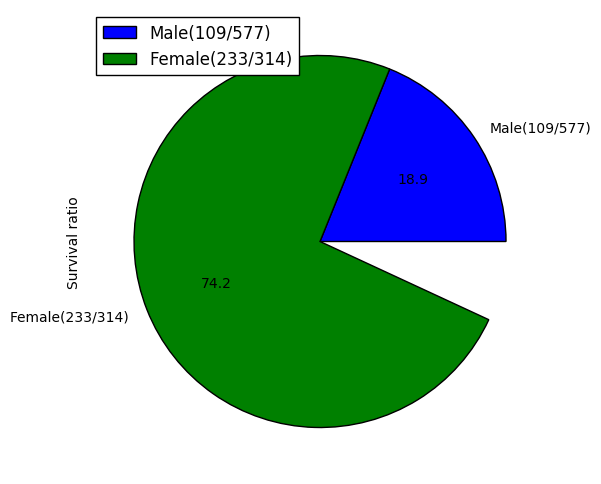

In [76]:
a1, a2, a3 = calc_survival(df, "sex", "male")
b1, b2, b3 = calc_survival(df, "sex", "female")
sex_group_df = pd.DataFrame(
    data={"Survival ratio": [a3, b3]},
    index=["Male", "Female"]
)

%pylab inline
import matplotlib.pyplot as plt

# 绘制直方图
sex_group_df.index = [
    "Male({0}/{1})".format(a1, a2), "Female({0}/{1})".format(b1, b2)
]
sex_group_df.plot(kind="bar")

# 绘制饼图
sex_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

### 3.3. 按level组进行分析
#### 3.3.1. 分组方式
> class1为一组，class2为一组，class3为一组

#### 3.3.2. 分析结果
> 从图中可以看出，class1有216名乘员，class2有184名乘员，class3有491名乘员，其中生还率class1 > class2 > class3

Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1130687d0>], dtype=object)

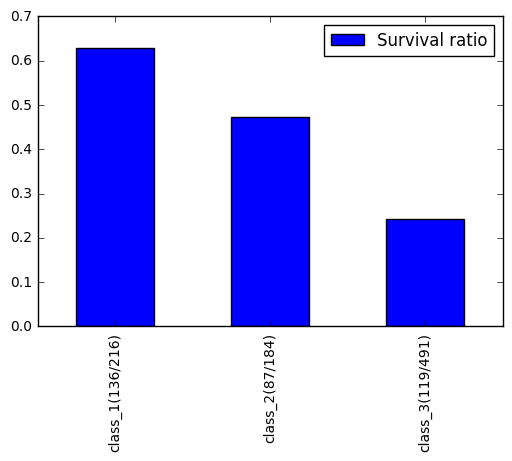

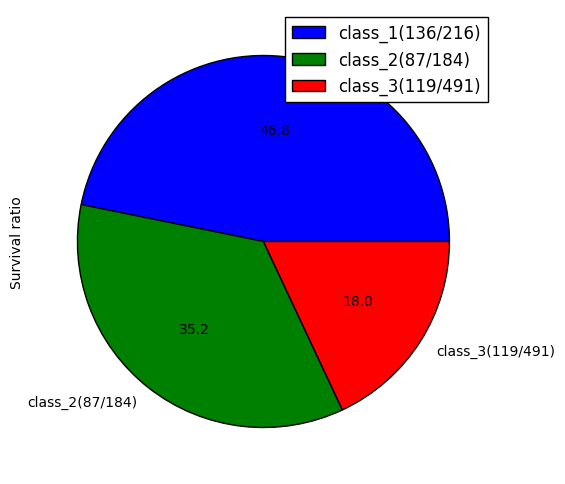

In [75]:
a1, a2, a3 = calc_survival(df, "level", 1)
b1, b2, b3 = calc_survival(df, "level", 2)
c1, c2, c3 = calc_survival(df, "level", 3)
class_group_df = pd.DataFrame(
    data={"Survival ratio": [a3, b3, c3]},
    index=["class 1", "class 2", "class 3"]
)

%pylab inline
import matplotlib.pyplot as plt

# 绘制直方图
class_group_df.index = [
    "class_1({0}/{1})".format(a1, a2), 
    "class_2({0}/{1})".format(b1, b2), 
    "class_3({0}/{1})".format(c1, c2)
]
class_group_df.plot(kind="bar")

# 绘制饼图
class_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

### 3.4. 按age_sex组进行分析
#### 3.4.1. 分组方式
> 按Child，Woman，Man分成三组

#### 3.4.2. 分析结果
> 从图中可以看出，child有139名，woman有192名，man有382名， 其中生还率woman>child>man

Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11081b190>], dtype=object)

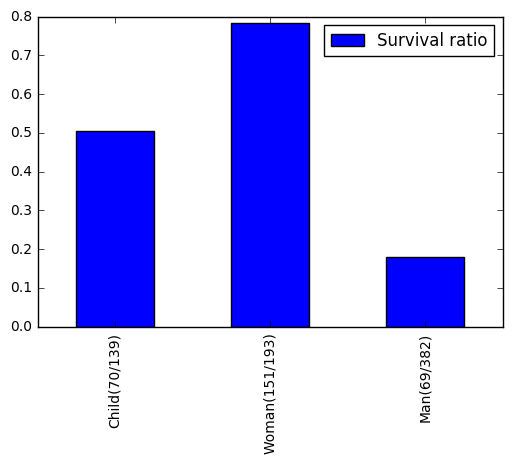

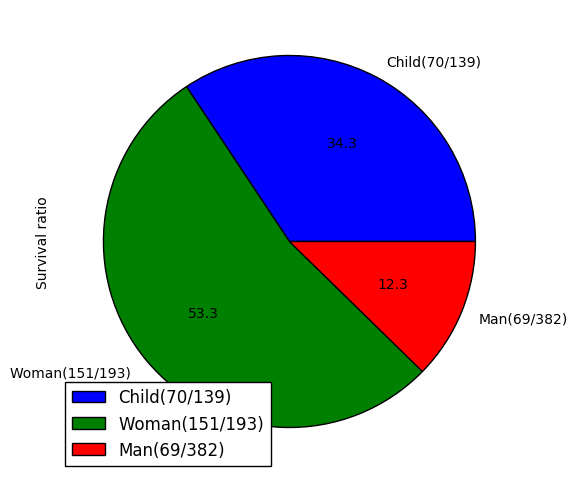

In [77]:
a1, a2, a3 = calc_survival(df, "age_sex", "child")
b1, b2, b3 = calc_survival(df, "age_sex", "woman")
c1, c2, c3 = calc_survival(df, "age_sex", "man")
age_sex_group_df = pd.DataFrame(
    data={"Survival ratio": [a3, b3, c3]},
    index=["Child", "Woman", "Man"]
)

%pylab inline
import matplotlib.pyplot as plt


# 绘制直方图
age_sex_group_df.index = [
    "Child({0}/{1})".format(a1, a2),
    "Woman({0}/{1})".format(b1, b2),
    "Man({0}/{1})".format(c1, c2)
]
age_sex_group_df.plot(kind="bar")

# 绘制饼图
age_sex_group_df.plot.pie(subplots=True, autopct='%.1f', figsize=(6, 6))

### 3.5. 按age+sex+level组进行分析
#### 3.5.1. 分组方式
> Child按class分三组，Woman按class分三组，Man按class分三组，

#### 3.5.2. 分析结果
> 从图可以看出，除了man中class3大约class2，其他乘员级别内都按class顺序排列；woman略高于child，man最低

child_1(14/16)
child_2(23/29)
child_3(33/94)
woman_1(72/74)
woman_2(54/60)
woman_3(25/59)
man_1(36/96)
man_2(6/84)
man_3(27/202)
Populating the interactive namespace from numpy and matplotlib


array([<matplotlib.axes._subplots.AxesSubplot object at 0x115499590>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x117c927d0>], dtype=object)

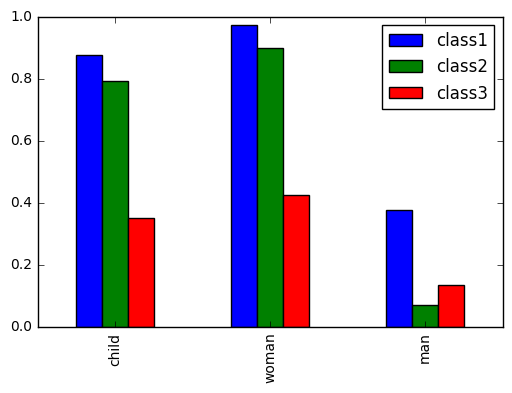

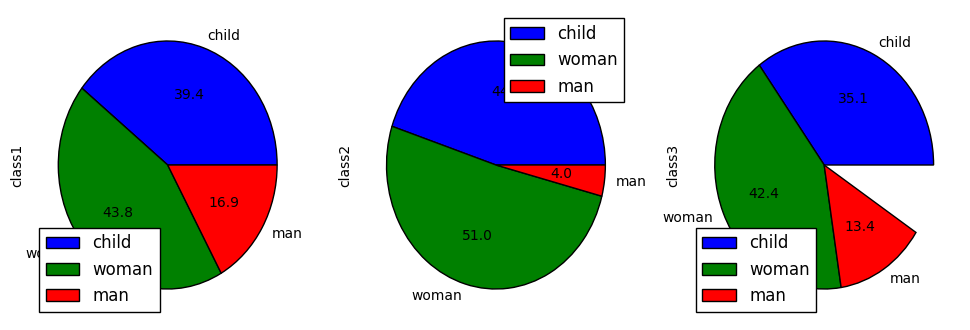

In [91]:
a1, a2, a3 = calc_survival(df, "age_sex_level", "child", 1)
b1, b2, b3 = calc_survival(df, "age_sex_level", "child", 2)
c1, c2, c3 = calc_survival(df, "age_sex_level", "child", 3)
d1, d2, d3 = calc_survival(df, "age_sex_level", "woman", 1)
e1, e2, e3 = calc_survival(df, "age_sex_level", "woman", 2)
f1, f2, f3 = calc_survival(df, "age_sex_level", "woman", 3)
g1, g2, g3 = calc_survival(df, "age_sex_level", "man", 1)
h1, h2, h3 = calc_survival(df, "age_sex_level", "man", 2)
i1, i2, i3 = calc_survival(df, "age_sex_level", "man", 3) 
print "child_1({0}/{1})".format(a1, a2)
print "child_2({0}/{1})".format(b1, b2)
print "child_3({0}/{1})".format(c1, c2)
print "woman_1({0}/{1})".format(d1, d2)
print "woman_2({0}/{1})".format(e1, e2)
print "woman_3({0}/{1})".format(f1, f2)
print "man_1({0}/{1})".format(g1, g2)
print "man_2({0}/{1})".format(h1, h2)
print "man_3({0}/{1})".format(i1, i2)

data = np.array([
            [a3, b3, c3],
            [d3, e3, f3],
            [g3, h3, i3],
            ])

age_class_group_saved_df = pd.DataFrame(
    data=data,
    index=["child", "woman", "man"],
    columns=["class1", "class2", "class3"]
)

%pylab inline
import matplotlib.pyplot as plt

# 绘制直方图
age_class_group_saved_df.index = ["child", "woman", "man"]
age_class_group_saved_df.plot(kind="bar")

# 绘制饼图(按照乘员级别画三个饼图)
age_class_group_saved_df.plot.pie(subplots=True, autopct='%.1f', figsize=(12, 4))

## 结论
> 从各种图得出，儿童和妇女的生还率是高于男子的。头等高于二等，二等高于三等，可能是因为头等在船的最上面，三等在最下面；但男子中二等的生还率
要低于三等，我觉得是有其他因素导致的。